In [1]:
import pandas as pd
import os, re
import csv
import numpy as np

In [2]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [3]:
chdir = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [5]:
# Metadata for specific SFC configurations
exp_ls = "exp-6"
vnfs = ["bridge.csv"]

In [6]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\bridge\\data", exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = np.nan
                stat.append(value)

    return list(map(lambda x:float(x), stat[:-1]))

In [7]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\bridge\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for i in range(len(lines)):
                try:
                    value = float(lines[i].strip()) / 1000
                except ValueError:
                    value= np.nan
                tmp.append(value)
    else:
        with open(os.path.join("..\\bridge\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = np.nan
                tmp.append(value)
                
    return tmp

In [8]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

1023

In [9]:
tx_stats = parse_seq("load_stimulus", exp_ls,  "tx_stats.csv")
len(tx_stats)

1025

In [10]:
rx_stats = parse_seq("load_stimulus", exp_ls,  "rx_stats.csv")
len(rx_stats)

1025

In [11]:
firewall_instructions = parse_reg("load_stimulus", exp_ls,  "bridge.csv", "instructions", 1)
len(firewall_instructions)

1024

In [12]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",'mem-stores','iTLB-loads','mem-loads','bus-cycles',]

In [13]:
def make_df():
    tmp = []
    dic = dict()

    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("load_stimulus", exp_ls, "bridge.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)


In [14]:
df = make_df()

<Axes: >

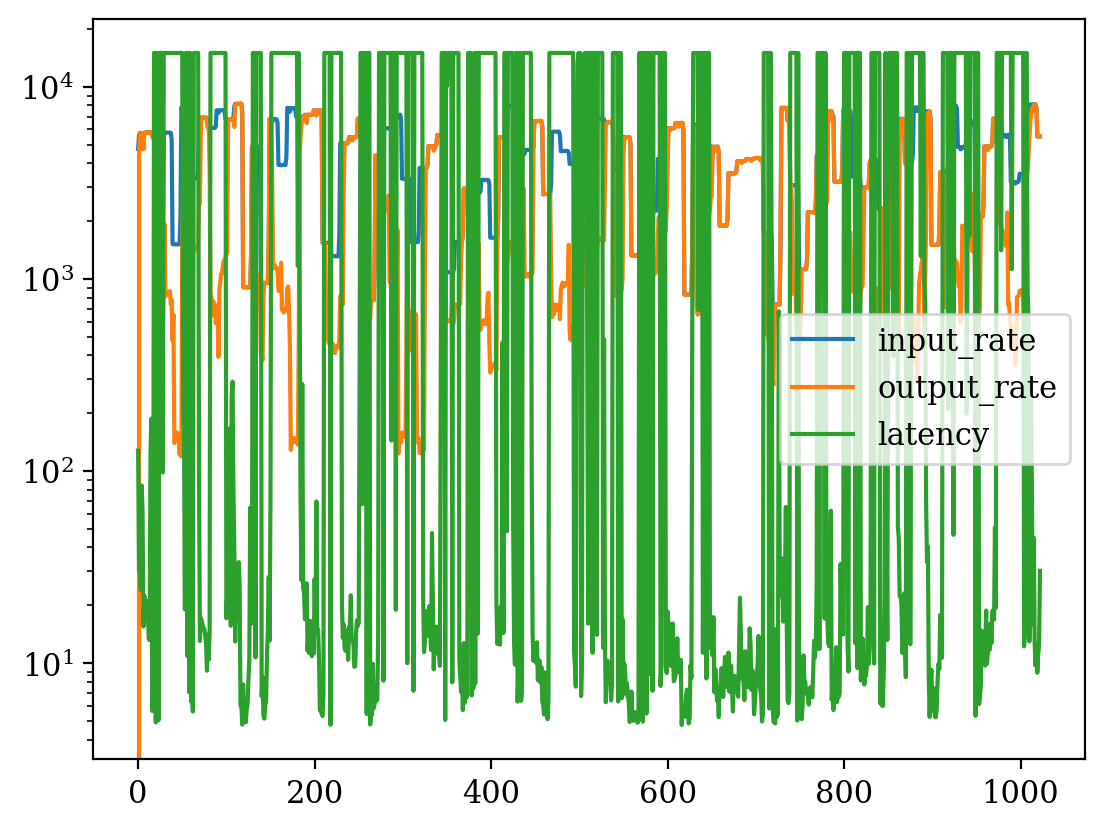

In [16]:
df.iloc[:, :3].plot(logy=True)

<Axes: >

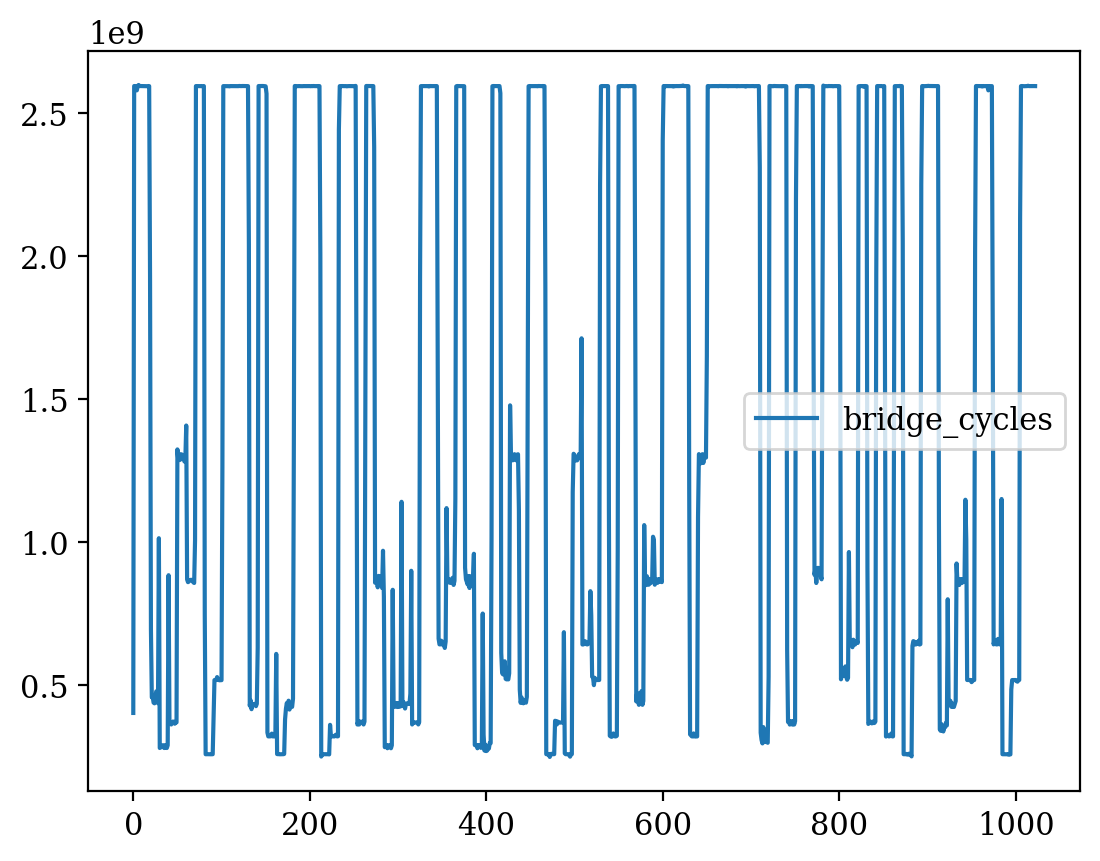

In [17]:
df[["bridge_cycles"]].plot()

<Axes: >

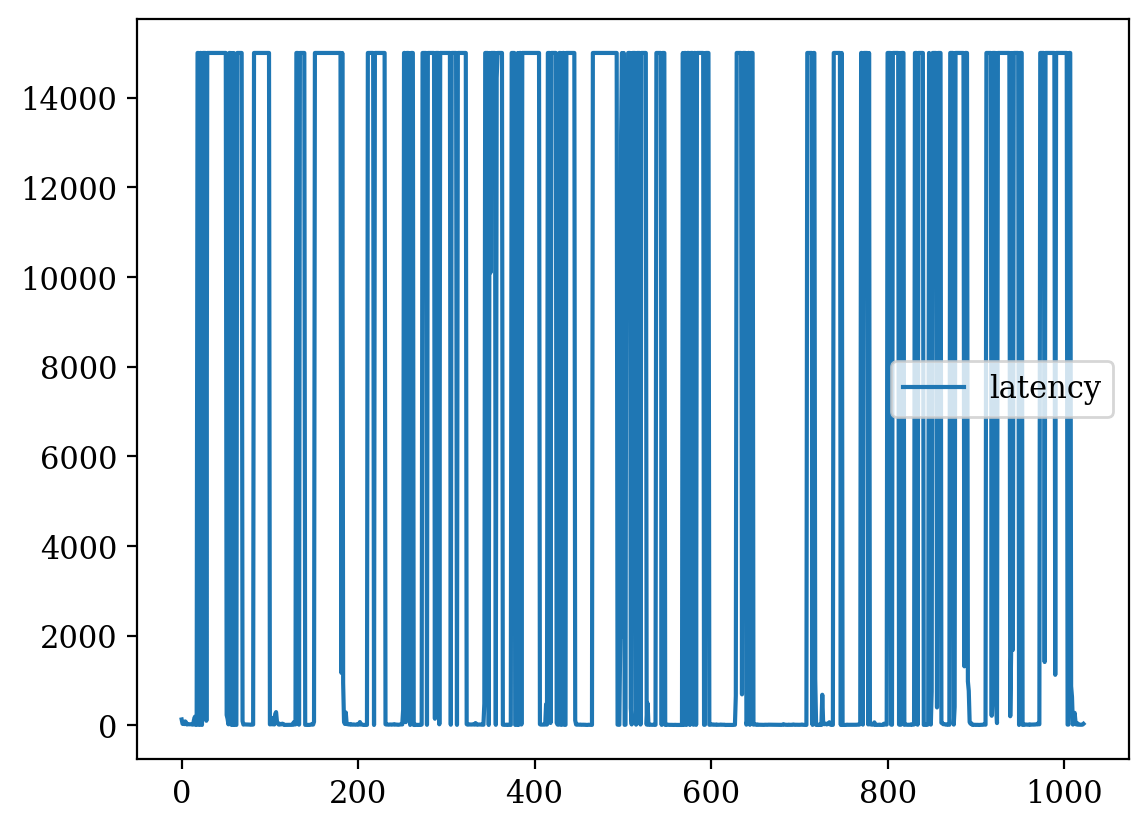

In [18]:
df[["latency"]].plot()

<Axes: >

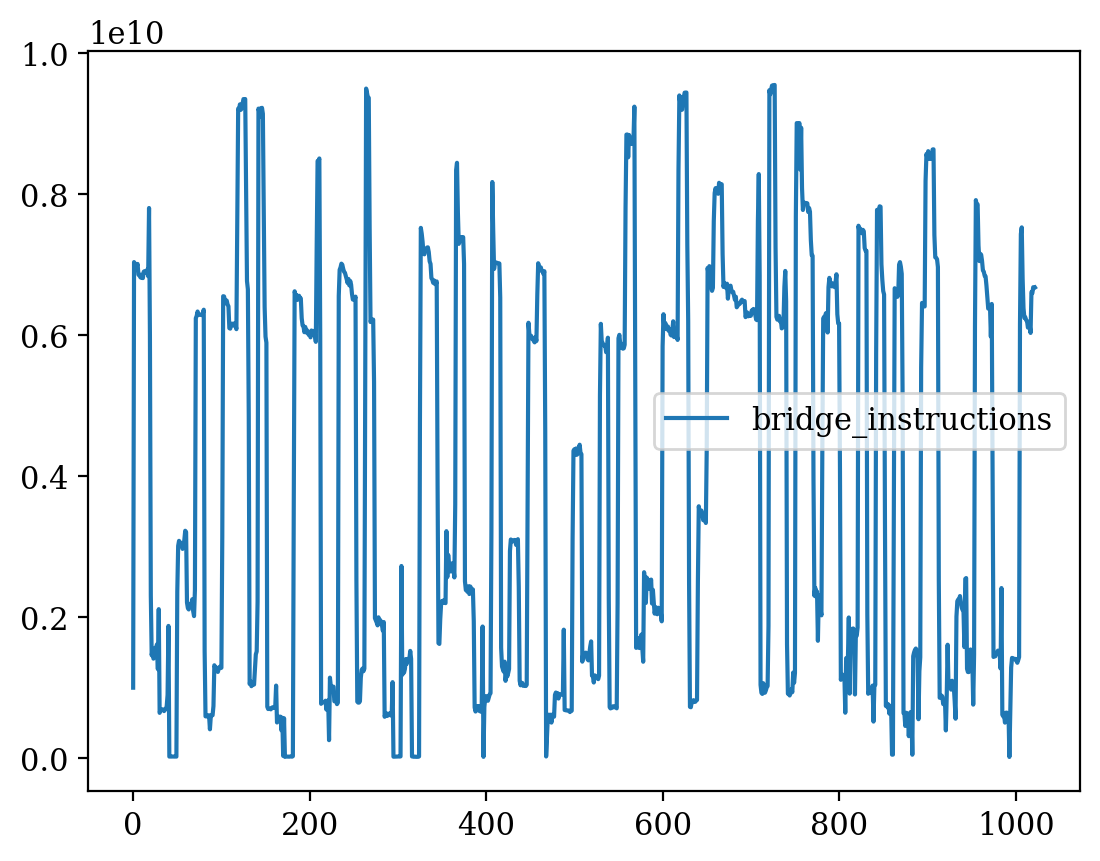

In [19]:
df[["bridge_instructions"]].plot()

<Axes: >

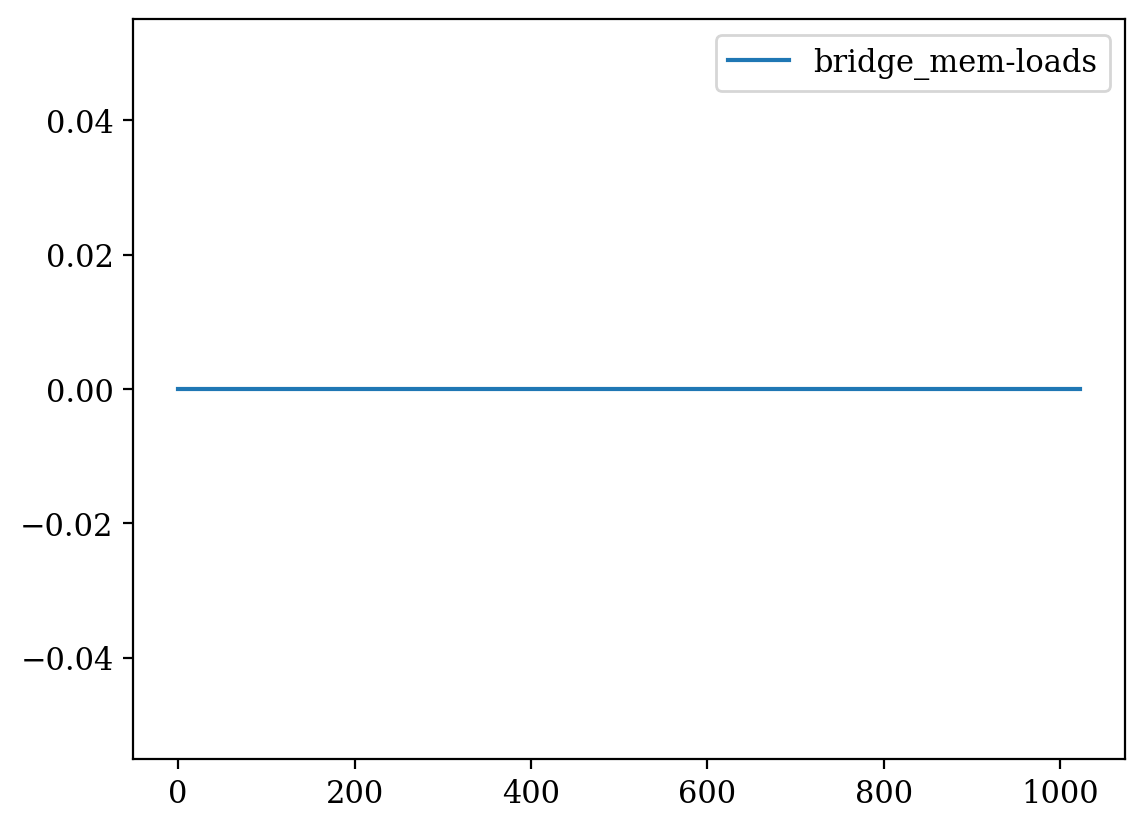

In [20]:
df[["bridge_mem-loads"]].plot()

In [21]:
abs_path = os.path.join("..\\bridge\\datasets", "load_stimulus_"+ exp_ls +".csv")
df.to_csv(abs_path, sep=',')
